In [1]:
#Importing the relevant packages
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Loading the relevant Datasets
books = pd.read_csv('/content/gdrive/MyDrive/books.csv', encoding='utf-8-sig')
ratings = pd.read_csv('/content/gdrive/MyDrive/ratings.csv', encoding='utf-8-sig')
to_read = pd.read_csv('/content/gdrive/MyDrive/to_read.csv', encoding='utf-8-sig')

## Data Preprocessing

### Preprocessing books dataframe

In [3]:
books.shape

(10000, 23)

In [4]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
books = books[['id','title','authors']]

In [6]:
books.rename(columns = {'id':'book_id'}, inplace = True) 

In [7]:
books.head()

,book_id,title,authors
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré"
2,3,"Twilight (Twilight, #1)",Stephenie Meyer
3,4,To Kill a Mockingbird,Harper Lee
4,5,The Great Gatsby,F. Scott Fitzgerald


In [8]:
#Removing the subtitle-title inside brackets from the 'title' column
books['title'] = books.title.str.replace(r"\(.*\)",'')

In [9]:
#Remove white space at the end of string
books.title = books.title.str.rstrip()

In [10]:
books.head()

,book_id,title,authors
0,1,The Hunger Games,Suzanne Collins
1,2,Harry Potter and the Sorcerer's Stone,"J.K. Rowling, Mary GrandPré"
2,3,Twilight,Stephenie Meyer
3,4,To Kill a Mockingbird,Harper Lee
4,5,The Great Gatsby,F. Scott Fitzgerald


### Preprocessing ratings dataframe

In [11]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [12]:
ratings.shape

(981756, 3)

In [13]:
#Removing duplicate records
ratings = ratings.drop_duplicates(subset=['book_id', 'user_id'], keep='last')

In [14]:
ratings.shape

(979478, 3)

In [15]:
#Getting unique users count
number_of_users = ratings['user_id'].unique()
len(number_of_users)

53424

In [16]:
count = ratings['user_id'].value_counts()
ratings = ratings[ratings['user_id'].isin(count[count >= 20].index)]
ratings.shape

(720212, 3)

In [17]:
#Getting unique users count
number_of_users = ratings['user_id'].unique()
len(number_of_users)

14612

In [18]:
#Getting unique books count
number_of_books = ratings['book_id'].unique()
len(number_of_books)

9999

### Let's start to recommend new books to particular user:

In [19]:
#Add user_id to the inserted user info
def get_books_info(user_id):
    
    books_info = pd.DataFrame()
    
    #Get past ratings history of inputed user
    books_info = ratings[ratings['user_id'] == user_id]
    
    #Merging to get the book Id.
    books_info = pd.merge(books_info, books, on='book_id', how='inner')
    books_info = books_info[['book_id', 'title', 'rating']].sort_values(by='book_id')

    return books_info

In [20]:
#let's select the subgroup of users. 
user_subset = pd.DataFrame()

def get_top_users(books_info):
    #Obtaining a list of users who have read the same books
    user_subset = ratings[ratings['book_id'].isin(books_info['book_id'].tolist())]
    
    #Group up the rows by user id
    user_subset = user_subset.groupby(['user_id'])
    
    #Let's sort these groups too, so users who read common books with input have a higher priority
    user_subset = sorted(user_subset,  key=lambda x: len(x[1]), reverse=True)
    
    #This limit(0-100) is set because we do not want to waste too much time on every user
    top_users = user_subset[1:101]
    
    return top_users

In [21]:
from scipy.stats import pearsonr

pearson_correlation = {}

def get_pearson_correlation(top_users, books_info):
    for user_id, group in top_users:
        #Let's start by sorting the input and current user group
        group = group.sort_values(by='book_id')
        books_info = books_info.sort_values(by='book_id')
        
        nratings = len(group)

        #Get the review scores for the movies that they both have in common
        temp = books_info[books_info['book_id'].isin(group['book_id'].tolist())]
        
        if nratings<2:
            continue

        #Store them in a temporary variable
        new_user_ratings = temp['rating'].tolist()
        #Store the current user group ratings
        user_ratings = group['rating'].tolist()

        corr = pearsonr(new_user_ratings, user_ratings)
        pearson_correlation[user_id] = corr[0]
            
    return pearson_correlation

In [22]:
#Let's get weighted rating for recommendation dataframe
def get_recommendation_df(pearson_correlation):
    #Converting the pearson_correlation output to a dataframe
    pearson_df = pd.DataFrame(columns=['user_id', 'similarity_value'], data=pearson_correlation.items())
    
    #Getting the top 50 users based on similarity value
    top_users = pearson_df.sort_values(by='similarity_value', ascending=False)[0:50]
    
    #Getting the book and rating of top users
    top_users_rating = top_users.merge(ratings, left_on='user_id', right_on='user_id', how='inner')
    
    #Multiplies the similarity by the user's ratings to get weighted rating
    top_users_rating['weighted_rating'] = top_users_rating['similarity_value']*top_users_rating['rating']
    
    #Getting the sum of similarity value and weighted rating by book id
    top_users_rating = top_users_rating.groupby('book_id').sum()[['similarity_value','weighted_rating']]
    top_users_rating.columns = ['sum_similarity_value','sum_weighted_rating']
    
    recommendation_df = pd.DataFrame()
    #Now we take the weighted average by book id
    recommendation_df['weighted_average_score'] = top_users_rating['sum_weighted_rating']/top_users_rating['sum_similarity_value']
    recommendation_df['book_id'] = top_users_rating.index
    
    #Ordering the book by weighted average score
    recommendation_df = recommendation_df[recommendation_df['weighted_average_score'] >= 2.5]
    recommendation = recommendation_df.sort_values(by='weighted_average_score', ascending=False).reset_index(drop=True)
    
    return recommendation

In [23]:
def get_recommend_books(user_id):
    
    books_info = get_books_info(user_id)
    top_users = get_top_users(books_info)
    pearson_correlation = get_pearson_correlation(top_users, books_info)

    recommendation = get_recommendation_df(pearson_correlation)

    #Finally recommended books for the inputted user
    recommend_books = books.loc[books['book_id'].isin(recommendation['book_id'].tolist())]
    recommend_books = pd.merge(recommend_books, recommendation, on='book_id', how='inner')
    recommend_books = recommend_books.sort_values(by='weighted_average_score', ascending=False).reset_index(drop=True)
    
    #print("\n Recommended Books(",num,"):")
    #print("\n Recommended Books:")
    return recommend_books

### Evaluate Accuracy

In [24]:
#Evaluate the recommended books of the particular user
def rec_accuracy(user_id):
    to_read_df = pd.DataFrame()
    #Get list of really recommended books from dataframe
    to_read_df = to_read[to_read['user_id'] == user_id]
    #Get length of really recommended books from dataframe
    to_read_len = len(to_read_df)
    
    #Get accuracy
    if to_read_len == 0:
        rec_book_len = 0
    else:
        #Get recommended books using pearson correlation
        rec_books = get_recommend_books(user_id)
        #Compare both lists of recommended books and get the number of matching books
        rec_book_len = len(rec_books.loc[rec_books['book_id'].isin(to_read_df['book_id'].tolist())].reset_index(drop=True))
        if rec_book_len == 0:
            to_read_len = 0
    
    #Calculat accuracy
    accuracy = 0
    if to_read_len == 0:
        accuracy = 0
    else:
        accuracy = rec_book_len/to_read_len
    
    return accuracy

In [25]:
#Get recommended books for the particular user
rec_books = get_recommend_books(314)
rec_books.head()

,book_id,title,authors,weighted_average_score
0,439,A Brief History of Time,"Stephen Hawking, Cao Chi, Phạm Văn Thiều",5.0
1,2225,John Dies at the End,David Wong,5.0
2,1957,I Capture the Castle,Dodie Smith,5.0
3,2513,Black House,"Stephen King, Peter Straub",5.0
4,4038,Marked / Betrayed / Chosen / Untamed,"P.C. Cast, Kristin Cast",5.0


In [26]:
#Get accuracy of recommended books for the particular user
rec_accuracy(314)

0.75

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

x1 = []
y1 = []
y2 = []
#Evaluate the recommended books with list of user
def total_accuracy(number_of_users):
    total_read_len = 0
    total_book_len = 0
    #Passing range of user inside loop
    for i in range(number_of_users):
        to_read_df = pd.DataFrame()
        #Get list of really recommended books from dataframe
        to_read_df = to_read[to_read['user_id'] == (i+1)]
        #Get length of really recommended books from dataframe
        to_read_len = len(to_read_df)

        if to_read_len == 0:
            rec_book_len = 0
        else:
            #Get recommended books using pearson correlation
            rec_books = get_recommend_books(i+1)
            #Compare both lists of recommended books and get the number of matching books
            rec_book_len = len(rec_books.loc[rec_books['book_id'].isin(to_read_df['book_id'].tolist())].reset_index(drop=True))
            if rec_book_len == 0:
                to_read_len = 0
        
        #Add together the number of books recommended by Pearson Correlation
        total_book_len = total_book_len + rec_book_len
        #Add together the number of books recommended by to_read dataframe
        total_read_len = total_read_len + to_read_len

        y1.append(to_read_len)
        y2.append(rec_book_len)
        x1.append(i+1)  
    
    #Calculate the overall accuracy
    accuracy = total_book_len / total_read_len

    print("\n")
    print("\n Total Recommended Books by DF: ",total_read_len)
    print("\n Total Recommended Books CF: ",total_book_len)
    print("\n")

    return accuracy

In [28]:
#Get overall accuracy of list of users
%time total_accuracy(100)




 Total Recommended Books by DF:  895

 Total Recommended Books CF:  455


CPU times: user 8.83 s, sys: 119 ms, total: 8.95 s
Wall time: 8.84 s


0.5083798882681564

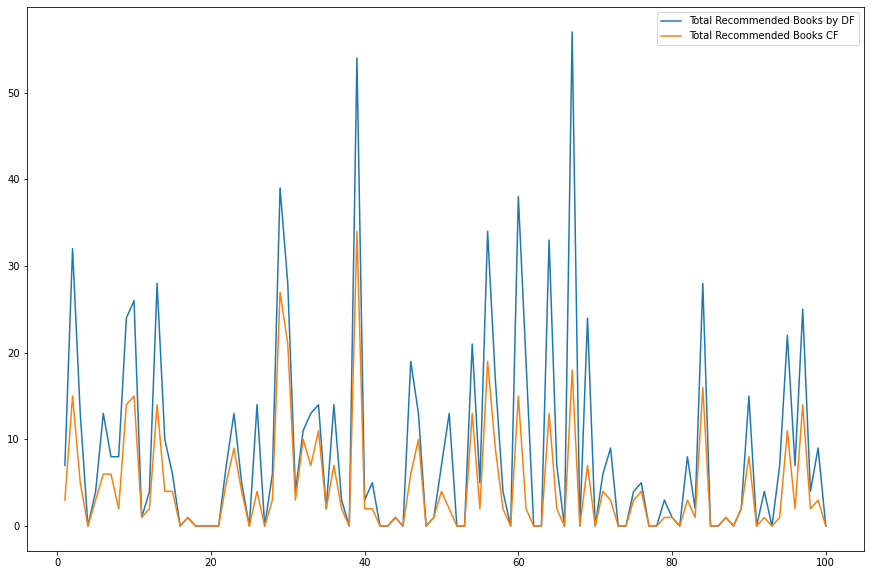

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(x1, y1)
plt.plot(x1, y2)
plt.legend(["Total Recommended Books by DF", "Total Recommended Books CF"])
plt.show()